### 네이버 영화리뷰 감성분석 도전하기

### 감성분석 사례
 - 마케팅 감성분석 사례 : https://dbr.donga.com/article/view/1202/article_no/8891/ac/magazine
 - 마케팅 감성분석 순서 : 데이터수집>데이터 전처리 > 형태소 사전의 구축 > 속성어(품사) 사전 구축 > 감성어 사전 구축 > 감성 분석 모형의 구축(감성어 사전별 점수 추출) 및 결과 도출(결과 계산)

<mark><b>[진행 순서]</b>

01. sentences 리스트 지정
02. 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개기
03. 텍스트: 인덱스 구조 만들기
04. 텍스트 데이터 숫자로 변경하기
05. 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode
- 숫자 벡터로 encode된 문장을 원래대로 decode하기
- 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하기
06. 임베딩 처리 *<주의> keras.preprocessing.sequence.pad_sequences 함수로 길이 맞추기
07. RNN 활용하기
08. CNN 계열의 Conv1D 활용하기  (장점 : 병렬처리로 학습속도가 빠름)
9. CNN 계열의 GlobalMaxPooling1D() 활용하기 (정해진 필터 크기에서 최댓값 추출)

In [1]:
# 1. 처리해야 할 문장을 파이썬 리스트에 옮겨 담았습니다.

sentences=['i feel hungry', 'i eat lunch', 'now i feel happy']

# 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개 봅니다.
word_list = 'i feel hungry'.split()
print(word_list)

['i', 'feel', 'hungry']


In [2]:
# 2. 파이썬 split() 메소드를 이용해 단어 단위로 문장을 쪼개기
index_to_word={}  # 빈 딕셔너리를 만들기

# 단어들을 하나씩 채우기
# <BOS>, <PAD>, <UNK>는 관례적으로 딕셔너리 맨 앞에 넣어줍니다. 
index_to_word[0]='<PAD>'  # 패딩용 단어
index_to_word[1]='<BOS>'  # 문장의 시작지점
index_to_word[2]='<UNK>'  # 사전에 없는(Unknown) 단어
index_to_word[3]='i'
index_to_word[4]='feel'
index_to_word[5]='hungry'
index_to_word[6]='eat'
index_to_word[7]='lunch'
index_to_word[8]='now'
index_to_word[9]='happy'

print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: 'i', 4: 'feel', 5: 'hungry', 6: 'eat', 7: 'lunch', 8: 'now', 9: 'happy'}


In [3]:
# 3. 텍스트를 숫자로 변경시 {텍스트:인덱스} 구조여야 한다.

word_to_index={word:index for index, word in index_to_word.items()}
print(word_to_index)

{'<PAD>': 0, '<BOS>': 1, '<UNK>': 2, 'i': 3, 'feel': 4, 'hungry': 5, 'eat': 6, 'lunch': 7, 'now': 8, 'happy': 9}


In [4]:
print(word_to_index['feel'])  # 단어 'feel'은 숫자 인덱스 4로 바뀝니다.

4


In [5]:
# 4. 텍스트 데이터 숫자로 변경하기
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 

def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] 
                                     if word in word_to_index 
                                     else word_to_index['<UNK>'] 
                                     for word in sentence.split()]

print(get_encoded_sentence('i eat lunch', word_to_index)) #문장의 시작지점인 BOS 1, i 3,  eat 6,  lunch 7 출력

[1, 3, 6, 7]


In [6]:
# 5. 여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode
# get_encoded_sentence 함수 사용 하기(여러 개의 문장 리스트를 한꺼번에 숫자 텐서로 encode

def get_encoded_sentences(sentences, word_to_index): 
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# encode 백터 변환 1. sentences 리스트 참고
encoded_sentences = get_encoded_sentences(sentences, word_to_index) 
print(encoded_sentences)

[[1, 3, 4, 5], [1, 3, 6, 7], [1, 8, 3, 4, 9]]


In [7]:
# 기타1. 숫자 벡터로 encode된 문장을 원래대로 decode하기
 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

print(get_decoded_sentence([1, 3, 4, 5], index_to_word))

i feel hungry


In [8]:
# 기타2.여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하기

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 7. encoded_sentence 리스트 변환  
print(get_decoded_sentences(encoded_sentences, index_to_word))

['i feel hungry', 'i eat lunch', 'now i feel happy']


In [9]:
# 6. 임베딩 처리 *raw_inputs 에 keras.preprocessing.sequence.pad_sequences 함수를 사용하여 패딩처리도 같이 진행

import numpy as np
import tensorflow as tf
from tensorflow import keras

vocab_size = len(word_to_index)  # 위 예시에서 딕셔너리에 포함된 단어 개수는 10
word_vector_dim = 4    # 그림과 같이 4차원의 워드 벡터를 가정합니다.

embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=word_vector_dim, mask_zero=True)

raw_inputs = np.array(get_encoded_sentences(sentences, word_to_index)) # embedding 레이어의 input이 될 수 있음에 주의 


raw_inputs = keras.preprocessing.sequence.pad_sequences(raw_inputs,
                                                       value=word_to_index['<PAD>'],
                                                       padding='post', #RNN은 입력데이터가 순차적으로 처리 마지막 입력이 무의미, 'pre'가 훨씬 유리
                                                       maxlen=5)
output = embedding(raw_inputs)
print(output) # output의 shape의 3은 입력문장 개수, 5는 maxlen(입력문장의 최대 길이), 4는 word_vector_dim(워드 벡터의 차원 수)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


tf.Tensor(
[[[-3.62790003e-02  2.35451572e-02 -2.72021536e-02  1.12747326e-02]
  [ 3.44746001e-02  6.08034059e-03 -2.88340803e-02  4.91940863e-02]
  [ 1.95310600e-02  3.64458226e-02  4.89302538e-02 -1.47814676e-03]
  [-1.62940845e-02  3.97322327e-03 -3.15822139e-02 -1.98922306e-03]
  [-4.14770842e-02 -2.51033437e-02  1.61983855e-02  1.47389211e-02]]

 [[-3.62790003e-02  2.35451572e-02 -2.72021536e-02  1.12747326e-02]
  [ 3.44746001e-02  6.08034059e-03 -2.88340803e-02  4.91940863e-02]
  [-3.57899182e-02  1.95243023e-02 -4.72370535e-03  1.45143755e-02]
  [ 1.59558542e-02  6.04356453e-03 -7.43754208e-05  1.31484382e-02]
  [-4.14770842e-02 -2.51033437e-02  1.61983855e-02  1.47389211e-02]]

 [[-3.62790003e-02  2.35451572e-02 -2.72021536e-02  1.12747326e-02]
  [ 2.11765282e-02  1.20259635e-02  2.34015249e-02  2.42548920e-02]
  [ 3.44746001e-02  6.08034059e-03 -2.88340803e-02  4.91940863e-02]
  [ 1.95310600e-02  3.64458226e-02  4.89302538e-02 -1.47814676e-03]
  [-3.69032398e-02 -3.76222357e-0

### RNN 모델의 종류
- 참고 : https://www.youtube.com/watch?v=-SHPG_KMUkQ&t=38s , [도서] 처음배우는 딥러닝 챗봇

- many to one : 데이터를 입력 받아 정산인지 비정상인지 판단 예) 스팸인지 판단하는 모델

- many to many 1 : 하나를 입력 받아 여러개를 출력 예) 이미지를 입력시 이미지를 설명하는 텍스트 출력

- many to many 2 : 여러개 입력 받아 여러개 출력  예) 동영상 실시간 프레임에 대한 분석 결과를 출력, 번역기


In [10]:
# 7. RNN 모델 활용하기 

vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 416       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 8. CNN 계열의 Conv1D 활용하기 (장점 : 병렬처리로 학습속도가 빠름)

vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          464       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [12]:
# 9. CNN 계열의 GlobalMaxPooling1D() 활용하기 (정해진 필터 크기에서 최댓값 추출)

vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 4)           40        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 4)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 40        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


### IMDb 영화리뷰 감성분석 태스크 도전
- 긍정1, 부정0 라벨, 5만개 영어 리뷰 텍스트로 구성(훈련용 데이터 50%, 테스트용 데이터 50% 사용하도록 지정)

<mark><b>[진행 순서]</b>

1. 데이터셋 다운로드 (encode된 텍스트 데이터를 다운로드) https://wikidocs.net/24586
2. 데이터셋 확인하기
- word_to_index 확인하기
3. word_to_index, index_to_word 보정
4. decode 된 데이터셋 확인
5. 케라스 패딩을 위한 도구  pad_sequences() 로 활용하기 https://wikidocs.net/83544
- 넘파이 padding='post': 뒤에 0을 채운다.
- 케라스 pad_sequences : 앞에 0을 채운다.
- max_len의 인자로 정수를 주면, 해당 정수로 모든 문서의 길이를 동일하게 한다.
- padding 방식 변경해 보기 -뒤쪽('post') 
- padding 방식 변경해 보기 -앞쪽('pre') *RNN은 입력데이터가 순차적으로 처리 마지막 입력이 무의미, 'pre'가 훨씬 유리

In [13]:
# 1. 데이터셋 다운로드 ( encode된 텍스트 데이터를 다운로드)

import tensorflow as tf
from tensorflow import keras
import numpy as np

print(tf.__version__)
imdb = keras.datasets.imdb

# IMDb 데이터셋 다운로드 
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(x_train), len(x_test)))

2.4.1


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


훈련 샘플 개수: 25000, 테스트 개수: 25000


/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [14]:
# 2. 데이터셋 확인하기

print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
라벨:  1
1번째 리뷰 문장 길이:  218
2번째 리뷰 문장 길이:  189


In [15]:
# word_to_index 확인하기

word_to_index = imdb.get_word_index() # imdb.get_word_index()에 각 단어와 맵핑되는 정수가 저장되어 있음
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word[1])     # 'the' 가 출력됩니다. 
print(word_to_index['the'])  # 1 이 출력됩니다.

the
1


In [16]:
# 3. word_to_index, index_to_word 보정
#  <주의> IMDB 리뷰 데이터셋에서 정한 규칙 : imdb.get_word_index()에 저장된 값에 +3을 해야 실제 맵핑

#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
word_to_index = {k:(v+3) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(word_to_index['the'])  # 4 이 출력됩니다. 
print(index_to_word[4])     # 'the' 가 출력됩니다.

<BOS>
4
the


In [17]:
# 4. decode 된 데이터셋 확인

print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they h

In [18]:
# 5. 케라스 패딩을 위한 도구  pad_sequences() 로 활용하기 

total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
#max_len의 인자로 정수를 주면, 해당 정수로 모든 문서의 길이를 동일하게 하며 값설젇이 전체 모델 성능에 영향
print('pad_sequences maxlen : ', maxlen) 
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  234.75892
문장길이 최대 :  2494
문장길이 표준편차 :  172.91149458735703
pad_sequences maxlen :  580
전체 문장의 0.94536%가 maxlen 설정값 이내에 포함됩니다. 


In [21]:
# padding 방식 변경해 보기  -뒤쪽('post') 
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(25000, 580)


In [22]:
# padding 방식 변경해 보기 -앞쪽('pre')  *RNN은 입력데이터가 순차적으로 처리 마지막 입력이 무의미, 'pre'가 훨씬 유리
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)  #이번 데이터셋은 차이를 모르겠음..

(25000, 580)


### IMDb 영화리뷰 감성분석 딥러닝 모델 설계와 훈련

<mark><b>[진행 순서]</b>

1. RNN 모델 설계
2. 훈련용 데이터셋 10000건을 분리하여 검증셋(validation set)으로 사용
3. 모델 학습
4. 모델 테스트셋으로 평가
5. epoch에 따른 그래프를 그려볼 수 있는 항목들
6. 그래프 Training and validation loss로 트레이닝 최적점 추정
7. 그래프 Training and validation accuracy 로 트레이닝 최적점 추정


In [23]:
# 1. RNN 모델 설계
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계(직접작성)
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


In [25]:
# 2. 훈련용 데이터셋 10000건을 분리하여 검증셋(validation set)으로 사용

# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(15000, 580)
(15000,)


In [28]:
# 3. 모델 학습
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 7s 139ms/step - loss: 0.6932 - accuracy: 0.5004 - val_loss: 0.6931 - val_accuracy: 0.5020
Epoch 2/20
30/30 [==============================] - 3s 107ms/step - loss: 0.6931 - accuracy: 0.5041 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 3/20
30/30 [==============================] - 3s 107ms/step - loss: 0.6929 - accuracy: 0.5170 - val_loss: 0.6933 - val_accuracy: 0.5033
Epoch 4/20
30/30 [==============================] - 3s 107ms/step - loss: 0.6925 - accuracy: 0.5275 - val_loss: 0.6930 - val_accuracy: 0.5025
Epoch 5/20
30/30 [==============================] - 3s 105ms/step - loss: 0.6923 - accuracy: 0.5159 - val_loss: 0.6927 - val_accuracy: 0.5030
Epoch 6/20
30/30 [==============================] - 3s 106ms/step - loss: 0.6910 - accuracy: 0.5209 - val_loss: 0.6921 - val_accuracy: 0.5042
Epoch 7/20
30/30 [==============================] - 3s 106ms/step - loss: 0.6884 - accuracy: 0.5189 - val_loss: 0.6912 - val_accuracy: 0.5034
Epoch 

In [29]:
# 4. 모델 테스트셋으로 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 21s - loss: 0.6952 - accuracy: 0.5096
[0.6952013969421387, 0.5095999836921692]


In [30]:
# 5.epoch에 따른 그래프를 그려볼 수 있는 항목들
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


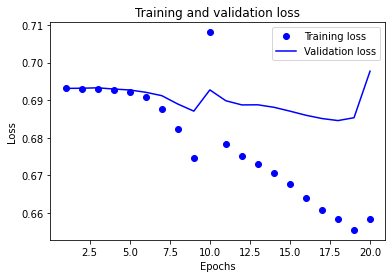

In [32]:
# 6. 그래프 Training and validation loss로 트레이닝 최적점 추정

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs') # Epochs 19정도에 lOSS가 제일 낮다.
plt.ylabel('Loss')
plt.legend()

plt.show()

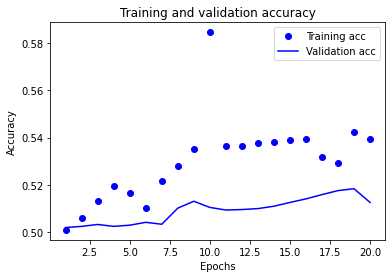

In [33]:
# 7. 그래프 Training and validation accuracy 로 트레이닝 최적점 추정

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs') # Epochs 10, 19정도에 Accuracy가 제일 높다.
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### IMDb 영화리뷰 감성분석 Word2Vec (연관단어 유추)
- CBOW 모델 : 맥락이라 표현되는 주변 단어들을 이용해 타깃 단어를 예측 ( 예: 오늘(주변단어) ___ (타깃단어)는 폭염이(주변단어) 심해요.)
- Skip-gram 모델 : 하나의 타깃 단어를 이용해 주변 단어들을 예측 ( 예: ----(주변단어) 치킨과(타깃단어)  --(주변단어)를 먹고 싶네요.)
- 워드 벡터를 다루기 위해 pip list | grep gensim 으로 패키지 버전 확인 필요

<mark><b>[진행 순서]</b>

1. RNN 모델 설계
2. 훈련용 데이터셋 10000건을 분리하여 검증셋(validation set)으로 사용
3. 모델 학습
4. 모델 테스트셋으로 평가
5. epoch에 따른 그래프를 그려볼 수 있는 항목들
6. 그래프 Training and validation loss로 트레이닝 최적점 추정
7. 그래프 Training and validation accuracy 로 트레이닝 최적점 추정

    pass

In [34]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [35]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [36]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['computer']
vector

/opt/conda/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


array([ 0.02726495, -0.0307985 , -0.04846679,  0.00099088,  0.09673243,
        0.10022417,  0.06375012,  0.03707759, -0.08080702, -0.09777314,
       -0.03772826,  0.06291641, -0.03981373,  0.08056346,  0.06454742,
       -0.10869022], dtype=float32)

In [37]:
word_vectors.similar_by_word("love")

[('forgiven', 0.8262287378311157),
 ('situations', 0.7804450392723083),
 ('nostalgic', 0.7531030774116516),
 ('shoe', 0.7499609589576721),
 ('of', 0.7454351186752319),
 ('wild', 0.7394944429397583),
 ('fi', 0.7391157150268555),
 ('everyone', 0.7352408766746521),
 ('does', 0.7328805327415466),
 ('outrageous', 0.7312945127487183)]

In [39]:
# Google의 Word2Vec 모델을 가져와 적용
# <준비> 클라우드 쉘에서 심볼링 링크를 연결하여 원본 파일을 직접 사용하는 것과 같은 효과를 내도록함
# 심볼링 링크  : ln -s ~/data/GoogleNews-vectors-negative300.bin.gz ~/aiffel 주소~

from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['computer']
vector     # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [40]:
# 메모리를 다소 많이 소비하는 작업이니 유의해 주세요.
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063),
 ('adores', 0.5440906882286072)]

In [41]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [42]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 580, 300)          3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 574, 16)           33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 114, 16)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 108, 16)           1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [43]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 17s 456ms/step - loss: 0.7317 - accuracy: 0.5066 - val_loss: 0.6830 - val_accuracy: 0.5630
Epoch 2/20
30/30 [==============================] - 11s 360ms/step - loss: 0.6587 - accuracy: 0.6260 - val_loss: 0.6461 - val_accuracy: 0.6353
Epoch 3/20
30/30 [==============================] - 11s 358ms/step - loss: 0.5801 - accuracy: 0.7351 - val_loss: 0.5387 - val_accuracy: 0.7226
Epoch 4/20
30/30 [==============================] - 11s 356ms/step - loss: 0.4250 - accuracy: 0.8299 - val_loss: 0.3847 - val_accuracy: 0.8366
Epoch 5/20
30/30 [==============================] - 11s 356ms/step - loss: 0.2768 - accuracy: 0.9041 - val_loss: 0.3460 - val_accuracy: 0.8500
Epoch 6/20
30/30 [==============================] - 11s 356ms/step - loss: 0.2006 - accuracy: 0.9326 - val_loss: 0.3151 - val_accuracy: 0.8685
Epoch 7/20
30/30 [==============================] - 11s 355ms/step - loss: 0.1393 - accuracy: 0.9623 - val_loss: 0.3117 - val_accuracy: 0.8730

In [44]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

782/782 - 8s - loss: 0.5163 - accuracy: 0.8647
[0.5162529349327087, 0.8647199869155884]


## 회고
1.*RNN은 입력데이터가 순차적으로 처리 마지막 입력이 무의미, 'pre'가 훨씬 유리하다는데 현재 데이터에선 같은 값으로 확인됨..
2. Training and validation loss 그래프의 Epochs 19정도에 lOSS가 제일 낮고, Training and validation accuracy 그래프의 Epochs 10, 19정도에 Accuracy가 제일 높다. 이에 19가 최적점으로 추정된다.